In [77]:
import pandas_datareader as pdr
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


(5052, 6)


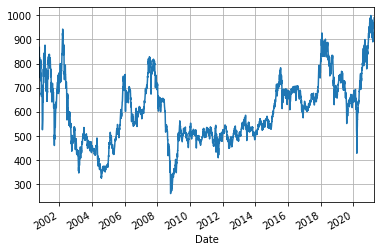

In [78]:
start = (2000, 1, 1)
start = datetime.datetime(*start)
end = datetime.date.today()

#yahoo에서 KOSDAQ 불러오기
df = pdr.DataReader('^KQ11','yahoo',start,end)
df.head(5)
df.tail(5)
df.Close.plot(grid=True)

print(df.shape)

In [87]:
# Dataset 준비

X = df
y = df.iloc[:,5:6]
y2 = df.iloc[1:,5:6]

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)
y_mm2 = mm.fit_transform(y2)
y_mm2 = np.insert(y_mm2,0,0,axis = 0)

# Train Data
# ############################################ random 하게 뽑아서 트레이닝 시키는걸로 바꿔보기!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

X_train = X_ss[0:4500,:]
X_test = X_ss[4500:len(X_ss)-1,:]
# print(len(X_train))
# print(len(X_test))

y_train = y_mm[1:4500+1,:]
y_test = y_mm[4500+1:len(X_ss),:]
# print(len(y_train))
# print(len(y_test))

print("data shape", X_train.shape, y_train.shape)


(5052, 1)
(5051, 1)
(5052, 1)
data shape (4500, 6) (4500, 1)


In [75]:
# Dataset을 이제 학습하기 위해 tensor 형태로 변환
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training shape : ",X_train_tensors_final.shape,y_train_tensors.shape)

device = torch.device("cpu")


Training shape :  torch.Size([4500, 1, 6]) torch.Size([4500, 1])


In [25]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.num_layers = num_layers
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        # Propagate input through LSTM
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        
        return out
    

num_epochs = 3000
learning_rate = 0.1

input_size = 6
hidden_size = 2
num_layers = 1

num_classes = 1

seq_length = 5

lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, 5).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm1.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = loss_function(outputs, y_train_tensors.to(device))
    loss.backward()
    
    optimizer.step() #backprop
    
    if epoch % 100 ==0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
        
  


Epoch: 0, loss: 0.54726
Epoch: 100, loss: 0.00281
Epoch: 200, loss: 0.00060
Epoch: 300, loss: 0.00032
Epoch: 400, loss: 0.00028
Epoch: 500, loss: 0.00026
Epoch: 600, loss: 0.00024
Epoch: 700, loss: 0.00023
Epoch: 800, loss: 0.00023
Epoch: 900, loss: 0.00022
Epoch: 1000, loss: 0.00022
Epoch: 1100, loss: 0.00021
Epoch: 1200, loss: 0.00020
Epoch: 1300, loss: 0.00020
Epoch: 1400, loss: 0.00019
Epoch: 1500, loss: 0.00019
Epoch: 1600, loss: 0.00018
Epoch: 1700, loss: 0.00019
Epoch: 1800, loss: 0.00018
Epoch: 1900, loss: 0.00017
Epoch: 2000, loss: 0.00017
Epoch: 2100, loss: 0.00023
Epoch: 2200, loss: 0.00031
Epoch: 2300, loss: 0.00017
Epoch: 2400, loss: 0.00017
Epoch: 2500, loss: 0.00017
Epoch: 2600, loss: 0.00023
Epoch: 2700, loss: 0.00017
Epoch: 2800, loss: 0.00017
Epoch: 2900, loss: 0.00020


(5051, 6)


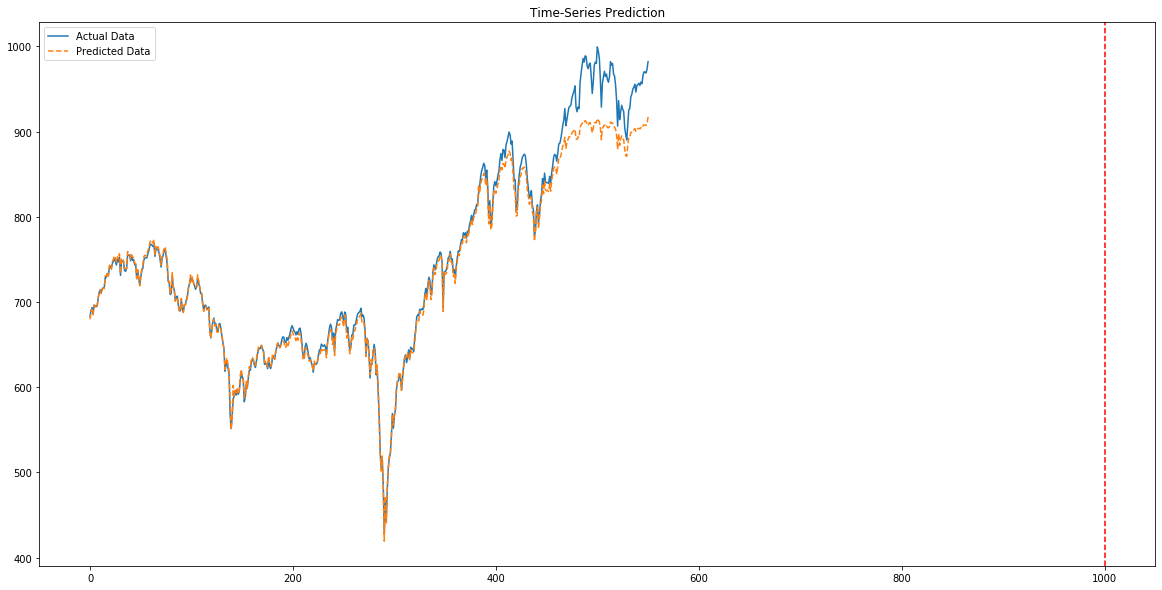

In [32]:
df_X_ss = ss.transform(df)
print(df.shape)
y_mm = df.iloc[:,5:6]
df_y_mm = mm.transform(y_mm)

df_X_ss = Variable(torch.Tensor(df_X_ss[4500:,:]))
df_y_mm = Variable(torch.Tensor(df_y_mm[4500:,:]))

df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0],1,df_X_ss.shape[1]))

train_pred = lstm1(df_X_ss.to(device))
data_pred = train_pred.data.detach().cpu().numpy()
dataY_plot = df_y_mm.data.numpy()

data_pred = mm.inverse_transform(data_pred)
dataY_plot = mm.inverse_transform(dataY_plot)

plt.figure(figsize=(20,10))
plt.axvline(x=1000, c='r', linestyle = '--')

plt.plot(dataY_plot, label='Actual Data')
plt.plot(data_pred, label = 'Predicted Data',linestyle = '--')

plt.title('Time-Series Prediction')
plt.legend()
plt.show()
